# Reliable Fully Local RAG Agents with LangGraph, Map Reduce, Parallelization, and Thread Memory

This notebook demonstrates how **thread memory** enhances the performance of RAG (Retrieval-Augmented Generation) agents by providing context through previous interactions. Additionally, improvements to prompts, graph state, and nodes, as well as the integration of new models for structured output, are showcased.

## **What Is Thread Memory?**

Thread memory, also referred to as **chat history**, allows the RAG agent to remember previous interactions in the conversation. By storing and referencing past messages, the agent can make more contextually relevant decisions, leading to more coherent and personalized responses.

Thread memory enables the agent to recall prior conversation history, improving its ability to maintain context over longer interactions.

## **How It Improves RAG Agents**

The use of thread memory improves RAG agents by:
- **Contextual Awareness**: The agent can recall past interactions, ensuring responses are coherent and contextually accurate.
- **Enhanced Dialogue Quality**: With thread memory, the chatbot can provide more personalized and relevant answers based on previous messages.
- **Improved Decision Making**: The agent uses thread memory to better understand user intent and adjust responses accordingly.

## **Key Benefits**

Thread memory improves RAG agents in the following ways:
- **Longer Context Retention**: The agent can remember previous messages, ensuring more accurate responses over time.
- **Personalized Interactions**: The chatbot can tailor responses based on prior conversations, enhancing user experience.
- **Improved Performance**: Combined with MapReduce and Parallelization, thread memory boosts the agent’s ability to process and respond more effectively, leveraging previous context to make decisions faster.


In [24]:
import logging
import operator
import os
import traceback
from functools import wraps
from typing import Annotated, Any, Dict, List

import chromadb
import httpx
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.schema import Document
from langchain_chroma import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import END, Send
from langgraph.graph import MessagesState, StateGraph
from pydantic import BaseModel, ValidationError
from typing_extensions import Literal, TypedDict
from unstructured.partition.pdf import partition_pdf

load_dotenv(dotenv_path="../../.env.research")

True

In [25]:
client = chromadb.HttpClient(
    host=os.getenv("CHROMA_HOST"), port=int(os.getenv("CHROMA_PORT"))
)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/auth/identity "HTTP/1.1 200 OK"
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/tenants/default_tenant "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database "HTTP/1.1 200 OK"


In [26]:
### LLM
local_llm = str(os.getenv("LLM_MODEL"))
llm = ChatOllama(model=local_llm, temperature=0.0)
embedder = OllamaEmbeddings(
    model=str(os.getenv("EMBEDDING_MODEL")), base_url=os.getenv("OLLAMA_URI")
)

In [27]:
if os.getenv("CHROMA_COLLECTION_NAME") in [
    collection.name for collection in client.list_collections()
]:
    client.delete_collection(os.getenv("CHROMA_COLLECTION_NAME"))

INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: DELETE http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/rummikub_rules_research "HTTP/1.1 200 OK"


In [28]:
if os.getenv("CHROMA_COLLECTION_NAME") not in [
    collection.name for collection in client.list_collections()
]:
    all_splits = partition_pdf(
        filename=os.path.join(os.getenv("DATA_DIR"), "rummikub_rules.pdf"),
        extract_images_in_pdf=False,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=1500,
        new_after_n_chars=1200,
        combine_text_under_n_chars=500,
    )
    texts = []
    for element in all_splits:
        if "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    vectorstore = None
    try:
        vectorstore = Chroma(
            client=client,
            collection_name=os.getenv("CHROMA_COLLECTION_NAME"),
            embedding_function=OllamaEmbeddings(
                model="nomic-embed-text", base_url=os.getenv("OLLAMA_URI")
            ),
        )
        vectorstore.add_texts(texts=texts)
    except httpx.ConnectError as e:
        logging.error(f"Could not connect to Chroma: {e}")
        vectorstore.delete_collection()

INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections "HTTP/1.1 200 OK"
INFO:unstructured_inference:Reading PDF for file: ../../data\rummikub_rules.pdf ...
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/pre-flight-checks "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/2a5784fe-c402-402e-9848-8de3734da53b/upsert "HTTP/1.1 200 OK"


In [29]:
### Retriever
vectorstore = Chroma(
    collection_name=os.getenv("CHROMA_COLLECTION_NAME"),
    client=client,
    embedding_function=embedder,
    create_collection_if_not_exists=False,
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

INFO:httpx:HTTP Request: GET http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/rummikub_rules_research "HTTP/1.1 200 OK"


## Components

In [30]:
### Improve Query
improve_query_instructions = """
You are tasked with improving the user's query to make it more relevant to Rummikub.

Guidelines:
1. **Question Analysis:**
   - **Do not force connections**: Avoid making assumptions or altering the query that does not align with the context.
   - **Do not make assumptions**: Never make assumptions about the question.

2. **Query Improvement:**
   - Focus on game elements such as rules, gameplay, sets, runs, scoring, etc.
   - Maintain original context and intent
   - Add relevant Rummikub terminology if necessary (e.g., tiles, sets, runs).
   - Do not copy the previous question verbatim.
   - You can use the previous context to understand the user's intent better.
"""

improve_query_prompt = """
Instructions:
{improve_query_instructions}

Previous context:
{formatted_context}

Latest question:
{latest_question}

Return JSON: ("improved_query": "<query>")
"""

In [31]:
### Router

router_instructions = """
You are a question router that classifies the user question into appropriate data sources based on their relevance to Rummikub.

It is important that you only return route information about the user's question and not the previous messages.

### Guidelines:
1. **Primary Task:**
   - Determine whether the user's question is about Rummikub. Questions should be about its rules, gameplay, strategy, tiles, or mechanics.
   - Analyze the previous messages and the user's question to make an informed decision. The user's question can be a follow-up or a new query.
   - Avoid assuming connections between unrelated topics and Rummikub unless explicitly stated by the user or derived from the context.

2. **Use Context Selectively:**
   - Only refer to the provided previous messages if the question is ambiguous and the context is necessary to make a decision.
   - Do not infer a connection between the question and Rummikub if it mentions unrelated terms, games, or concepts.

3. **Return:**
It is important to not include any other information in the response other than the structured output.
Call the RoutingInformation tool for the structured output so that the output is in the correct format.
"""

router_prompt = """
Analyze the user’s question and determine the most appropriate data source.
Look at the previous messages and the user's question to make an informed decision. If the question is connected to the previous messages which makes it clear that the question is about Rummikub, then route it either to the vectorstore or websearch depending on the context.
Do not force a connection between the question and Rummikub if it is not related. Do not make assumptions or reinterpret the question to fit Rummikub.
Do not make rules up or provide information that is not supported by the context.
It is important that you make one routing decision of the users question and not the previous messages.

#### Context About Rummikub:
Rummikub is a **tile-based** game where players aim to be the first to empty their rack by forming valid sets or runs of numbered tiles. The game involves two types of valid combinations: sets (groups of the same number in different colors) and runs (consecutive numbers in the same color). Jokers can substitute for any tile. Questions about other games or concepts are unrelated.

#### User’s Question:
{question}

#### Previous Messages:
{formatted_context}

### Task:
1. Decide the appropriate <datasource>:
   - **`vectorstore`:** For questions explicitly about Rummikub.
   - **`websearch`:** For questions about recent events or updates related to Rummikub.
   - **`irrelevant`:** For all other questions, including those about unrelated topics.

2. Provide <reasoning> for your choice:
   - Explain briefly why the question fits the selected category.
   - For unclear questions, explain why the context provided does or does not clarify the intent.
"""

In [32]:
### Retrieval Grader

doc_grader_instructions = """
You are an evaluator tasked with determining the relevance of a retrieved document to a user's question.

Use the following **criteria for relevance**:
1. **Direct Match**: The document directly addresses the user's question by answering it or discussing its main subject.
2. **Contextual Help**: Even if the document does not provide a direct answer, it could offer partial information, context, or clues that contribute to answering the question. This is considered relevant.
3. **Alignment**: The document must contain specific keywords, synonyms, phrases, or related ideas that align closely with the user's question.

**Important Considerations**:
- Be **strict but fair**: Grade as 'not relevant' only if the document provides no meaningful connection to the user's question.
- Avoid being overly conservative: Even partial or incomplete information should be considered relevant if it adds value to the answer.
- Use an **objective lens**: Base your decision solely on the content of the document and its connection to the question, without assumptions.

Your evaluation must balance strictness with fairness to ensure that useful documents are not unnecessarily excluded.
"""

doc_grader_prompt = """
Here is a retrieved document:

{document}

Here is the user's question:

{improved_query}

Using the criteria provided:
1. Determine whether the document is relevant to the question.
2. Base your assessment on whether the document directly or indirectly addresses the question, provides partial information, or offers contextual relevance. These are all considered relevant.

Return JSON with a single key, `binary_score`, as either 'yes' (relevant) or 'no' (not relevant). Make your assessment objective and based solely on the content of the document and its alignment with the question.
"""

In [33]:
### Generate

rag_instructions = """
You are an assistant tasked with answering questions about Rummikub based on provided context. Your response must be well-structured, professional, and formatted for clear readability.

### Evaluation Criteria for Responses
1. **Accuracy**: Your answer must be directly supported by the provided context.
2. **Clarity**: Provide straightforward, clear, and concise answers. Avoid redundant phrases or ambiguous phrasing.
3. **Completeness**: Fully address the user question based on the available context and improved query. If the context is insufficient, indicate this and offer actionable suggestions.
4. **Relevance**: Stick strictly to the information derived from the provided context. Avoid unnecessary repetition of the query or context unless essential for clarity.
5. **Presentation**: Avoid unnecessary headers like **Answer** or extraneous symbols such as `/n`. Format the response in a clean, natural style.

### Best Practices
- **Stay Grounded**: Only provide information found in the context.
- **Address Insufficient Context**: If the context is incomplete or missing, acknowledge this and offer guidance on what additional details might help.
- **Direct and User-Friendly**: Structure your response to directly address the query without redundant elaboration. Use a tone that is helpful and professional.
- **Clean Formatting**: Ensure the output is formatted as a single, clean paragraph or structured list when appropriate.
"""

rag_prompt = """
You are an assistant tasked with answering questions about Rummikub based on the provided context.

### Context
{context}

### User Question
{question}

### User Improved Query
{improved_query}

### Task
1. **Review the Context**: Carefully analyze the provided context to extract the most relevant information for answering the question.
2. **Improved Query**: Use the improved query to guide your response if the users question is unclear or ambiguous. But always try to answer the user's question directly.
3. **Handle Insufficient Context**: If the context does not provide sufficient information to answer the question:
   - Acknowledge the insufficiency explicitly.
   - Suggest additional clarifications or details needed to proceed.
4. **Answer Clearly**: Write a concise, direct, and user-friendly response. Avoid any unnecessary elaboration or repetition.
5. **Formatting**:
   - Avoid extraneous symbols, headers (like **Answer:**), or redundant breaks.
   - Present the answer as a clean paragraph or list, depending on the nature of the question.

### Deliverable
Provide a concise, well-structured response to the query based solely on the given context.
"""

rag_prompt_after_hallucination = """
You are an assistant tasked with answering questions about Rummikub based on the provided context.

### Context
{context}

### User Question
{question}

### User Improved Query
{improved_query}

### Previous Hallucinated Response
{previous_response}

### Task
Your goal is to provide a factual and contextually accurate response, avoiding any inaccuracies or unsupported claims from the previous response.

1. **Stay Grounded**: Ensure your answer is entirely based on the provided context. Do not include details, assumptions, or fabrications not explicitly found in the context.
2. **Avoid Hallucination**: Treat the previous response only as a reference for what to avoid. Do not rephrase or reuse its content.
3. **Improved Query**: Use the improved query to guide your response if the users question is unclear or ambiguous. But always try to answer the user's question directly.
4. **Conciseness**: Provide a clear and direct answer. Only repeat information from the context verbatim if absolutely necessary.
5. **Formatting**: Present the response cleanly:
   - Avoid unnecessary headers, symbols, or line breaks.
   - Structure the response as a single clean paragraph or structured list.
6. **Transparency**: If the context does not contain sufficient information:
   - Clearly state the insufficiency.
   - Explain why the context wasn’t helpful.
   - Suggest additional clarifications or details for the user to provide.

### Deliverable
Write a concise and well-structured response to the user’s query, formatted for easy readability and based solely on the context provided.
"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [34]:
### Hallucination Grader


hallucination_grader_instructions = """

You are a teacher grading a quiz.

You will be given FACTS, a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS.

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
"""

hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n QUESTION: {question} \n\n STUDENT ANSWER: {generation}.

Return JSON with one key, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS."""

In [35]:
### Answer Grader

answer_grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
"""

answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.

Return JSON with one key, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria."""

In [36]:
web_search_tool = TavilySearchResults(max_results=3)

In [37]:
# Custom exception classes and functions

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class NodeError(Exception):
    """Base exception for node-specific errors"""

    pass


class DocumentProcessingError(NodeError):
    """Raised when document processing fails"""

    pass


class LLMError(NodeError):
    """Raised when LLM operations fail"""

    pass


class WebSearchError(NodeError):
    """Raised when web search operations fail"""

    pass


def handle_node_errors(func):
    """
    Decorator for handling common node errors and providing fallback behavior.
    """

    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except ValidationError as e:
            logger.error(f"Validation error in {func.__name__}: {str(e)}")
            raise NodeError(f"Invalid data structure: {str(e)}")
        except LLMError as e:
            logger.error(f"LLM error in {func.__name__}: {str(e)}")
            return handle_llm_fallback(func.__name__)
        except WebSearchError as e:
            logger.error(f"Web search error in {func.__name__}: {str(e)}")
            return {
                "documents": [],
                "loop_web_search": kwargs.get("state", {}).get("loop_web_search", 0)
                + 1,
            }
        except Exception as e:
            logger.error(
                f"Unexpected error in {func.__name__}: {str(e)}\n{traceback.format_exc()}"
            )
            raise NodeError(f"Unexpected error: {str(e)}")

    return wrapper


def handle_llm_fallback(node_name: str) -> Dict[str, Any]:
    """
    Provides fallback behavior for LLM failures based on the node type.
    """
    fallbacks = {
        "improve_query": {"improved_query": "", "question": ""},
        "grade_document": {"filtered_docs": [], "grades": []},
        "generate": {
            "loop_generate": 0,
            "messages": [
                AIMessage(
                    content="I apologize, but I'm having trouble processing your request. Could you please rephrase your question?"
                )
            ],
        },
    }
    return fallbacks.get(node_name, {})

In [38]:
# Models


class ImprovedQuery(BaseModel):
    """Model for improved query response from the LLM"""

    improved_query: str


class RouteInformation(BaseModel):
    """An answer from the router with routing information based on the user's question"""

    datasource: Literal["vectorstore", "websearch", "irrelevant"]
    reasoning: str


class Grade(BaseModel):
    """Model for grading response from the LLM"""

    binary_score: Literal["yes", "no"]


class GenerateResponse(BaseModel):
    """Model for generation response from the LLM"""

    generation: str

In [39]:
### State


class OverallState(MessagesState):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    improved_query: str
    question: str
    web_search: str
    max_retries: int
    loop_generate: int
    loop_web_search: int
    documents: List[str]
    filtered_docs: Annotated[list[str], operator.add]
    grades: Annotated[list[str], operator.add]
    hallucination_grade: bool
    answer_grade: bool
    decision: str
    route: str


class OutputRouterState(TypedDict):
    """
    Output schema for the router
    """

    question: str
    route: str


class InputRetrieverState(TypedDict):
    """
    Input schema for the retriever
    """

    improved_query: str


class InputProceedToDatasourceState(TypedDict):
    """
    Input schema for the proceed_to_datasource node
    """

    route: str


class InputGeneratorState(MessagesState):
    """
    Input schema for the generator
    """

    improved_query: str
    filtered_docs: List[str]
    loop_generate: int
    hallucination_grade: bool
    question: str


class OutputRetrieverState(TypedDict):
    """
    Output schema for the retriever
    """

    documents: List[str]


class OutputGeneratorState(MessagesState):
    """
    Output schema for the generator
    """

    loop_generate: int


class InputContinueToGradingsState(TypedDict):
    """
    Input schema for the continue_to_gradings node
    """

    documents: List[str]
    improved_query: str


class InputDocumentGraderState(TypedDict):
    """
    Input schema for the document grader
    """

    document: str
    improved_query: str


class OutputDocumentGraderState(TypedDict):
    """
    Output schema for the document grader
    """

    filtered_docs: Annotated[list[str], operator.add]
    grades: Annotated[list[str], operator.add]


class InputDocumentsGradingsState(TypedDict):
    """
    Input schema for the documents gradings node
    """

    grades: List[str]
    loop_web_search: int
    max_retries: int


class OutputDocumentsGradingsState(TypedDict):
    """
    Output schema for the documents gradings node
    """

    web_search: str
    grades: List[str]


class InputWebSearchState(TypedDict):
    """
    Input schema for the web search node
    """

    improved_query: str
    question: str
    loop_web_search: int


class ImproveQueryState(TypedDict):
    """
    Input schema for the improvement web search node
    """

    improved_query: str
    route: str


class InputImproveQueryState(MessagesState):
    """
    Input schema for the web search node
    """

    question: str
    route: str


class OutputWebSearchState(TypedDict):
    """
    Output schema for the web search node
    """

    documents: List[str]
    loop_web_search: int


class InputDecisionState(TypedDict):
    """
    Input schema for the decision node
    """

    web_search: str


class InputHallucinationGraderState(MessagesState):
    """
    Input schema for the hallucination grader
    """

    filtered_docs: List[str]
    question: str


class OutputHallucinationGraderState(TypedDict):
    """
    Output schema for the hallucination grader
    """

    hallucination_grade: bool


class OutputAnswerGraderState(TypedDict):
    """
    Output schema for the hallucination grader
    """

    answer_grade: bool


class InputAnswerGraderState(MessagesState):
    """
    Input schema for the answer grader
    """

    question: str


class InputGradersState(TypedDict):
    """
    Input schema for the node which checks the gradings of the hallucination and answer grader
    """

    hallucination_grade: bool
    answer_grade: bool
    max_retries: int
    loop_generate: int
    loop_web_search: int


class OutputGradersState(TypedDict):
    """
    Output schema for the node which checks the gradings of the hallucination and answer grader
    """

    decision: str


class InputResetState(TypedDict):
    """
    Input schema for the reset state node
    """

    filtered_docs: List[str]
    grades: List[str]
    documents: List[str]


class OutputResetState(TypedDict):
    """
    Output schema for the reset state node
    """

    filtered_docs: List[str]
    grades: List[str]
    documents: List[str]
    loop_generate: int
    question: str
    web_search: str
    decision: str
    loop_web_search: int
    improved_query: str
    hallucination_grade: bool
    answer_grade: bool

In [40]:
### Nodes


@handle_node_errors
def route_question(state: MessagesState) -> OutputRouterState:
    """
    Route question to web search or RAG or none

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call

    Raises:
        ValidationError: If input validation fails
        LLMError: If routing question fails
    """
    logger.info("---ROUTE QUESTION---")
    try:
        question = state["messages"][-1].content
        context_messages = [
            f"{msg.type}: {msg.content}" for msg in state["messages"][-9:-1]
        ]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    try:
        formatted_context = "\n".join(context_messages)
        router_llm = llm.with_structured_output(RouteInformation)
        route_question_prompt_formatted = router_prompt.format(
            question=question, formatted_context=formatted_context
        )
        route_question_response: RouteInformation = router_llm.invoke(
            [
                SystemMessage(content=router_instructions),
                HumanMessage(content=route_question_prompt_formatted),
            ]
        )

        return {"route": route_question_response.datasource, "question": question}
    except Exception as e:
        raise LLMError(f"Routing question failed: {str(e)}")


@handle_node_errors
def improve_query(state: InputImproveQueryState) -> ImproveQueryState:
    """
    Improve the query based on the question for vectorstore and web search.

    Args:
        state: Contains messages with user query history

    Returns:
        Dictionary with the improved query and original question

    Raises:
        LLMError: If query improvement fails
        ValidationError: If input validation fails
    """
    logger.info("---IMPROVE QUERY---")
    try:
        question = state["question"]

        context_messages = [
            f"{msg.type}: {msg.content}" for msg in state["messages"][-9:-1]
        ]
        route = state["route"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    try:
        formatted_context = "\n".join(context_messages)
        improve_query_prompt_formatted = improve_query_prompt.format(
            formatted_context=formatted_context,
            latest_question=question,
            improve_query_instructions=improve_query_instructions,
        )
        structured_llm = llm.with_structured_output(ImprovedQuery)
        llm_response: ImprovedQuery = structured_llm.invoke(
            [HumanMessage(content=improve_query_prompt_formatted)]
        )
        return {"improved_query": llm_response.improved_query, "route": route}
    except Exception as e:
        raise LLMError(f"Query improvement failed: {str(e)}")


@handle_node_errors
def proceed_to_datasource(state: InputProceedToDatasourceState) -> str:
    """
    Proceed to the datasource based on the route

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call

    Raises:
        ValidationError: If input validation fails
    """
    try:
        route = state["route"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    if route == "vectorstore":
        logger.info("---PROCEED TO VECTORSTORE---")
        return "vectorstore"
    elif route == "websearch":
        logger.info("---PROCEED TO WEB SEARCH---")
        return "search web"


@handle_node_errors
def retrieve(state: InputRetrieverState) -> OutputRetrieverState:
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents

    Raises:
        DocumentProcessingError: If document retrieval fails
    """
    logger.info("---RETRIEVE---")
    try:
        improved_query = state["improved_query"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    try:
        documents = retriever.invoke(improved_query)
        return {"documents": documents}
    except Exception as e:
        raise DocumentProcessingError(f"Document retrieval failed: {str(e)}")


@handle_node_errors
def continue_to_gradings(state: InputContinueToGradingsState) -> List[Send]:
    """
    Continue to grade the documents for relevance to the user's question

    Args:
        state (dict): The current graph state

    Returns:
        list: List of Send objects to grade each document

    Raises:
        ValidationError: If input validation fails
    """
    try:
        improved_query = state["improved_query"]
        documents = state["documents"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    return [
        Send(
            "grade_document",
            {"document": d, "improved_query": improved_query},
        )
        for d in documents
    ]


@handle_node_errors
def grade_document(state: InputDocumentGraderState) -> OutputDocumentGraderState:
    """
    Grades a document for relevance to the user's question.

    Args:
        state (dict): The current graph state.

    Returns:
        dict: New keys added to the state, `filtered_docs` and `grades`.

    Raises:
        ValidationError: If input validation fails
        LLMError: If document grading fails
    """
    try:
        improved_query = state["improved_query"]
        doc = state["document"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    try:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=doc.page_content, improved_query=improved_query
        )
        document_grader_llm = llm.with_structured_output(Grade)
        result: Grade = document_grader_llm.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = result.binary_score
        if grade.lower() == "yes":
            logger.info("---GRADE: DOCUMENT RELEVANT---")
            return {"filtered_docs": [doc], "grades": [grade]}
        else:
            logger.info("---GRADE: DOCUMENT NOT RELEVANT---")
            return {"grades": [grade], "filtered_docs": []}
    except Exception as e:
        raise LLMError(f"Document grading failed: {str(e)}")


@handle_node_errors
def grade_docs(state: InputDocumentsGradingsState) -> OutputDocumentsGradingsState:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state

    Raises:
        ValidationError: If input validation fails
    """
    logger.info("---CHECK IF WEB SEARCH IS NECESSARY---")
    try:
        grades = state.get("grades", [])
        max_retries = state.get("max_retries", 3)
        loop_web_search = state.get("loop_web_search", 0)
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")
    if loop_web_search >= max_retries:
        logger.info("---MAX RETRIES REACHED---")
        web_search = "No"
    elif all(x.lower() == "no" for x in grades):
        logger.info("---NO RELEVANT DOCUMENTS---")
        web_search = "Yes"
    else:
        logger.info("---RELEVANT DOCUMENTS FOUND---")
        web_search = "No"
    grades.clear()
    return {"web_search": web_search, "grades": grades}


@handle_node_errors
def decide_to_generate(state: InputDecisionState) -> str:
    """
    Determines whether to generate an answer or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call

    Raises:
        ValidationError: If input validation fails
    """

    logger.info("---ASSESS GRADED DOCUMENTS---")
    try:
        web_search = state["web_search"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    if web_search == "Yes":
        logger.info("---DECISION: NO RELEVANT DOCUMENTS, INCLUDE WEB SEARCH---")
        return "search web"
    else:
        logger.info("---DECISION: GENERATE---")
        return "generate response"


@handle_node_errors
def generate(state: InputGeneratorState) -> OutputGeneratorState:
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation

    Raises:
        ValidationError: If input validation fails
        DocumentProcessingError: If document processing fails
        LLMError: If generation fails
    """
    try:
        improved_query = state["improved_query"]
        documents = state["filtered_docs"]
        halucination_grade = state.get("hallucination_grade", False)
        loop_generate = state.get("loop_generate", 0)
        last_message = state["messages"][-1]
        question = state["question"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    try:
        docs_txt = format_docs(documents)
    except Exception as e:
        raise DocumentProcessingError(f"Document processing failed: {str(e)}")
    generation_llm = llm.with_structured_output(GenerateResponse)
    if halucination_grade:
        logger.info("---ADJUST GENERATION AFTER HALLUCINATION---")
        try:
            rag_halucination_prompt_formatted = rag_prompt_after_hallucination.format(
                context=docs_txt,
                improved_query=improved_query,
                previous_response=last_message.content,
                question=question,
            )
            generation: GenerateResponse = generation_llm.invoke(
                [SystemMessage(content=rag_instructions)]
                + [HumanMessage(content=rag_halucination_prompt_formatted)]
            )
            return {
                "loop_generate": loop_generate + 1,
                "messages": [
                    AIMessage(content=generation.generation, id=last_message.id)
                ],
            }
        except Exception as e:
            raise LLMError(f"Generation after hallucination failed: {str(e)}")

    logger.info("---GENERATE---")
    try:
        rag_prompt_formatted = rag_prompt.format(
            context=docs_txt, improved_query=improved_query, question=question
        )
        generation = generation_llm.invoke(
            [SystemMessage(content=rag_instructions)]
            + [HumanMessage(content=rag_prompt_formatted)]
        )
        return {
            "loop_generate": loop_generate + 1,
            "messages": [AIMessage(content=generation.generation)],
        }
    except Exception as e:
        raise LLMError(f"Generation failed: {str(e)}")


@handle_node_errors
def search_web(state: InputWebSearchState) -> OutputWebSearchState:
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents

    Raises:
        ValidationError: If input validation fails
        WebSearchError: If web search fails
    """

    logger.info("---WEB SEARCH---")
    try:
        query = state["improved_query"]
        loop_web_search = state.get("loop_web_search", 0)
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")
    try:
        docs = web_search_tool.invoke({"query": query})
        web_results = "\n".join([d["content"] for d in docs])
        documents = [Document(page_content=web_results)]
        return {"documents": documents, "loop_web_search": loop_web_search + 1}
    except Exception as e:
        raise WebSearchError(f"Web search failed: {str(e)}")


@handle_node_errors
def grade_hallucination(
    state: InputHallucinationGraderState,
) -> OutputHallucinationGraderState:
    """
    Determines whether the generation is grounded in the document

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call

    Raises:
        ValidationError: If input validation fails
        LLMError: If hallucination grading fails
    """
    logger.info("---GRADE HALLUCINATION---")
    try:
        documents = state["filtered_docs"]
        generation = state["messages"][-1]
        question = state["question"]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")
    try:
        hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
            documents=format_docs(documents),
            generation=generation.content,
            question=question,
        )
        hallucination_llm = llm.with_structured_output(Grade)
        result: Grade = hallucination_llm.invoke(
            [SystemMessage(content=hallucination_grader_instructions)]
            + [HumanMessage(content=hallucination_grader_prompt_formatted)]
        )
        grade = result.binary_score
        if grade.lower() == "yes":
            logger.info("---DECISION: GENERATION GROUNDED IN DOCUMENT---")
            return {"hallucination_grade": False}
        return {"hallucination_grade": True}
    except Exception as e:
        raise LLMError(f"Hallucination grading failed: {str(e)}")


@handle_node_errors
def grade_answer(state: InputAnswerGraderState) -> OutputAnswerGraderState:
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call

    Raises:
        ValidationError: If input validation fails
    """

    logger.info("---GRADE GENERATION vs QUESTION---")
    try:
        question = state["question"]
        generation = state["messages"][-1]
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")
    try:
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        answer_llm = llm.with_structured_output(Grade)
        result: Grade = answer_llm.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = result.binary_score
        if grade.lower() == "yes":
            logger.info("---DECISION: GENERATION ADDRESSES QUESTION---")
            return {"answer_grade": False}
        return {"answer_grade": True}
    except Exception as e:
        raise LLMError(f"Answer grading failed: {str(e)}")


@handle_node_errors
def grade_generation_v_documents_and_question(
    state: InputGradersState,
) -> OutputGradersState:
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call

    Raises:
        ValidationError: If input validation fails
    """

    logger.info("---CHECK GRADINGS---")
    try:
        hallucination_grade = state.get("hallucination_grade", False)
        answer_grade = state.get("answer_grade", False)
        max_retries = state.get("max_retries", 3)
        loop_generate = state.get("loop_generate", 0)
        loo_web_search = state.get("loop_web_search", 0)
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")

    if not hallucination_grade and not answer_grade:
        logger.info("---DECISION: GENERATION ADDRESSES QUESTION---")
        decision = "useful"
    elif loop_generate >= max_retries or loo_web_search >= max_retries:
        logger.info("---DECISION: MAX RETRIES REACHED---")
        decision = "max retries"
    elif answer_grade:
        logger.info("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        decision = "not useful"
    elif hallucination_grade:
        logger.info("---DECISION: GENERATION HALLUCINATED---")
        decision = "not supported"
    else:
        logger.info("---DECISION: GENERATION NOT GRADED---")
        decision = "not supported"
    return {"decision": decision}


def handle_irrelevant(state) -> MessagesState:
    """
    Handle irrelevant questions
    :param state: The current graph state
    :return: New message to add to the state
    """
    logger.info("---HANDLE IRRELEVANT---")
    irrelevant_message = AIMessage(
        content="The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub."
    )
    return {"messages": [irrelevant_message]}


@handle_node_errors
def reset_state(state: InputResetState) -> OutputResetState:
    """
    Reset the state while keeping messages intact.

    Args:
        state: The current state object

    Returns:
        dict: The reset state object

    Raises:
        ValidationError: If input validation fails
    """
    logger.info("---RESET STATE---")
    try:
        filtered_docs = state.get("filtered_docs", [])
        grades = state.get("grades", [])
        documents = state.get("documents", [])
        documents.clear()
        filtered_docs.clear()
        grades.clear()
    except (KeyError, IndexError) as e:
        raise ValidationError(f"Invalid input state: {str(e)}")
    return {
        "filtered_docs": filtered_docs,
        "grades": grades,
        "documents": documents,
        "loop_generate": 0,
        "question": "",
        "web_search": "",
        "decision": "",
        "loop_web_search": 0,
        "improved_query": "",
        "hallucination_grade": False,
        "answer_grade": False,
    }

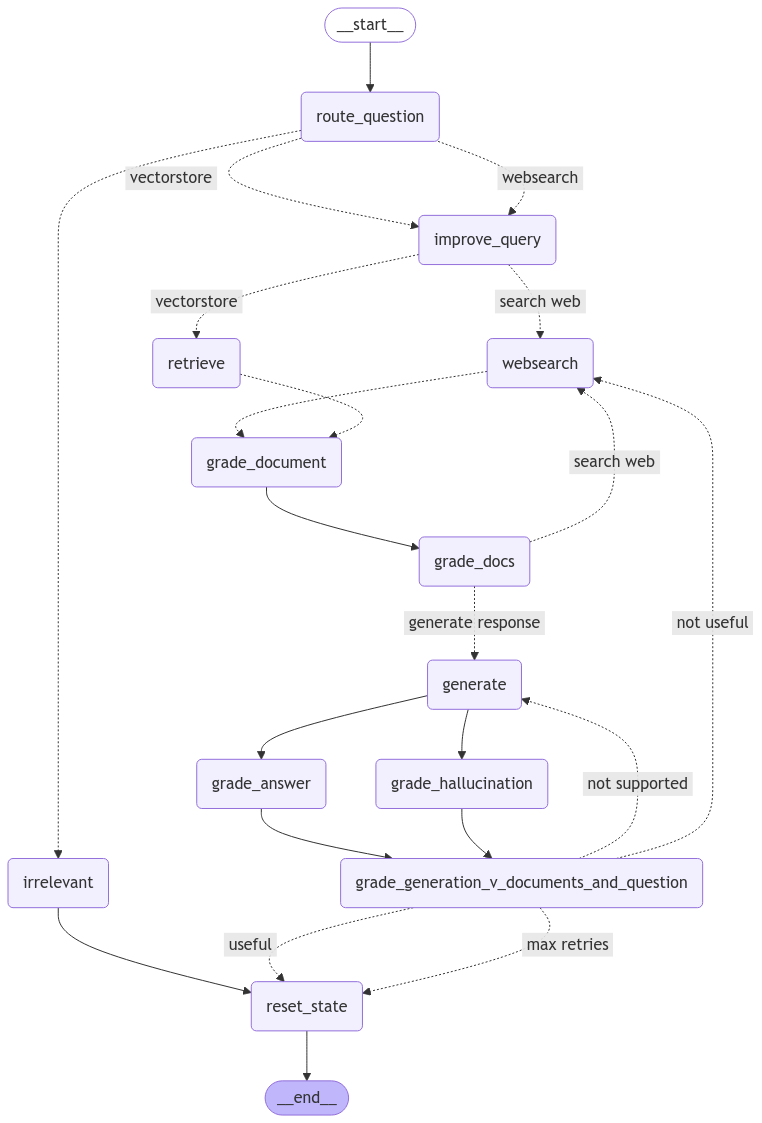

In [41]:
workflow = StateGraph(OverallState, input=MessagesState, output=MessagesState)

# Define the nodes
workflow.add_node("improve_query", improve_query)  # vectorstore
workflow.add_node("route_question", route_question)  # route question
workflow.add_node("websearch", search_web)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("irrelevant", handle_irrelevant)  # handle irrelevant
workflow.add_node("grade_document", grade_document)  # grade document
workflow.add_node("grade_docs", grade_docs)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("grade_hallucination", grade_hallucination)  # grade hallucination
workflow.add_node("grade_answer", grade_answer)  # grade answer
workflow.add_node(
    "grade_generation_v_documents_and_question",
    grade_generation_v_documents_and_question,
)  # grade generation vs documents and question
workflow.add_node("reset_state", reset_state)  # reset state

# Build graph
workflow.set_entry_point("route_question")
workflow.add_conditional_edges(
    "route_question",
    lambda x: x["route"],
    {
        "vectorstore": "improve_query",
        "websearch": "improve_query",
        "irrelevant": "irrelevant",
    },
)
workflow.add_conditional_edges(
    "improve_query",
    proceed_to_datasource,
    {"search web": "websearch", "vectorstore": "retrieve"},
)
workflow.add_conditional_edges("websearch", continue_to_gradings, ["grade_document"])
workflow.add_conditional_edges("retrieve", continue_to_gradings, ["grade_document"])
workflow.add_edge("grade_document", "grade_docs")
workflow.add_conditional_edges(
    "grade_docs",
    decide_to_generate,
    {
        "search web": "websearch",
        "generate response": "generate",
    },
)
workflow.add_edge("generate", "grade_hallucination")
workflow.add_edge("generate", "grade_answer")
workflow.add_edge("grade_hallucination", "grade_generation_v_documents_and_question")
workflow.add_edge("grade_answer", "grade_generation_v_documents_and_question")
workflow.add_conditional_edges(
    "grade_generation_v_documents_and_question",
    lambda x: x["decision"],
    {
        "not supported": "generate",
        "useful": "reset_state",
        "not useful": "websearch",
        "max retries": "reset_state",
    },
)
workflow.add_edge("irrelevant", "reset_state")
workflow.add_edge("reset_state", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "2"}}

inputs = {
    "messages": ["What are the models released today for llama3.2?"],
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values", config=config):
    print(event)

In [ ]:
config = {"configurable": {"thread_id": "2"}}

inputs = {
    "messages": ["With how many tiles does each player start with?"],
    "max_retries": 3,
}

for event in graph.stream(inputs, stream_mode="values", config=config):
    print(event)

In [386]:
config = {"configurable": {"thread_id": "2"}}

inputs = {
    "messages": ["Okay and what do we do after that?"],
    "max_retries": 3,
}

for event in graph.stream(inputs, stream_mode="values", config=config):
    print(event)

INFO:__main__:---ROUTE QUESTION---


{'messages': [HumanMessage(content='What are the models released today for llama3.2?', additional_kwargs={}, response_metadata={}, id='b8d0c28f-038f-4990-97a2-2cecf929a3b2'), AIMessage(content='The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.', additional_kwargs={}, response_metadata={}, id='05b9efdc-93ca-4dfc-b770-d8648825d30c'), HumanMessage(content='With how many tiles does each player start with?', additional_kwargs={}, response_metadata={}, id='1079f330-cc89-4bb6-8ad5-ed8ca6146b96'), AIMessage(content='Each player starts with 14 tiles.', additional_kwargs={}, response_metadata={}, id='f53b11c4-b5de-4652-8cfb-96818fe360e0'), HumanMessage(content='Okay and what do we do after that?', additional_kwargs={}, response_metadata={}, id='e04e28af-b0cc-48be-bc24-501a4bb6b652')], 'improved_query': '', 'question': '', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': [], 'filtered_docs': [], 'grades':

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---IMPROVE QUERY---


{'messages': [HumanMessage(content='What are the models released today for llama3.2?', additional_kwargs={}, response_metadata={}, id='b8d0c28f-038f-4990-97a2-2cecf929a3b2'), AIMessage(content='The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.', additional_kwargs={}, response_metadata={}, id='05b9efdc-93ca-4dfc-b770-d8648825d30c'), HumanMessage(content='With how many tiles does each player start with?', additional_kwargs={}, response_metadata={}, id='1079f330-cc89-4bb6-8ad5-ed8ca6146b96'), AIMessage(content='Each player starts with 14 tiles.', additional_kwargs={}, response_metadata={}, id='f53b11c4-b5de-4652-8cfb-96818fe360e0'), HumanMessage(content='Okay and what do we do after that?', additional_kwargs={}, response_metadata={}, id='e04e28af-b0cc-48be-bc24-501a4bb6b652')], 'improved_query': '', 'question': 'Okay and what do we do after that?', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---PROCEED TO VECTORSTORE---
INFO:__main__:---RETRIEVE---
INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/3d1a31a4-275f-43c1-bc00-4ab3f1aad184/query "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What are the models released today for llama3.2?', additional_kwargs={}, response_metadata={}, id='b8d0c28f-038f-4990-97a2-2cecf929a3b2'), AIMessage(content='The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.', additional_kwargs={}, response_metadata={}, id='05b9efdc-93ca-4dfc-b770-d8648825d30c'), HumanMessage(content='With how many tiles does each player start with?', additional_kwargs={}, response_metadata={}, id='1079f330-cc89-4bb6-8ad5-ed8ca6146b96'), AIMessage(content='Each player starts with 14 tiles.', additional_kwargs={}, response_metadata={}, id='f53b11c4-b5de-4652-8cfb-96818fe360e0'), HumanMessage(content='Okay and what do we do after that?', additional_kwargs={}, response_metadata={}, id='e04e28af-b0cc-48be-bc24-501a4bb6b652')], 'improved_query': 'what do we do after that?', 'question': 'Okay and what do we do after that?', 'web_search': '', 'loop_generate': 0, 'loop_web_

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY---
INFO:__main__:---RELEVANT DOCUMENTS FOUND---
INFO:__main__:---ASSESS GRADED DOCUMENTS---
INFO:__main__:---DECISION: GENERATE---
INFO:__main__:---GENERATE---


{'messages': [HumanMessage(content='What are the models released today for llama3.2?', additional_kwargs={}, response_metadata={}, id='b8d0c28f-038f-4990-97a2-2cecf929a3b2'), AIMessage(content='The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.', additional_kwargs={}, response_metadata={}, id='05b9efdc-93ca-4dfc-b770-d8648825d30c'), HumanMessage(content='With how many tiles does each player start with?', additional_kwargs={}, response_metadata={}, id='1079f330-cc89-4bb6-8ad5-ed8ca6146b96'), AIMessage(content='Each player starts with 14 tiles.', additional_kwargs={}, response_metadata={}, id='f53b11c4-b5de-4652-8cfb-96818fe360e0'), HumanMessage(content='Okay and what do we do after that?', additional_kwargs={}, response_metadata={}, id='e04e28af-b0cc-48be-bc24-501a4bb6b652')], 'improved_query': 'what do we do after that?', 'question': 'Okay and what do we do after that?', 'web_search': '', 'loop_generate': 0, 'loop_web_

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE HALLUCINATION---
INFO:__main__:---GRADE GENERATION vs QUESTION---


{'messages': [HumanMessage(content='What are the models released today for llama3.2?', additional_kwargs={}, response_metadata={}, id='b8d0c28f-038f-4990-97a2-2cecf929a3b2'), AIMessage(content='The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.', additional_kwargs={}, response_metadata={}, id='05b9efdc-93ca-4dfc-b770-d8648825d30c'), HumanMessage(content='With how many tiles does each player start with?', additional_kwargs={}, response_metadata={}, id='1079f330-cc89-4bb6-8ad5-ed8ca6146b96'), AIMessage(content='Each player starts with 14 tiles.', additional_kwargs={}, response_metadata={}, id='f53b11c4-b5de-4652-8cfb-96818fe360e0'), HumanMessage(content='Okay and what do we do after that?', additional_kwargs={}, response_metadata={}, id='e04e28af-b0cc-48be-bc24-501a4bb6b652'), AIMessage(content='After the initial meld, players can add tiles to existing sets on the table, rearrange or manipulate tiles to create new valid 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---DECISION: GENERATION GROUNDED IN DOCUMENT---
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION ADDRESSES QUESTION---
INFO:__main__:---RESET STATE---


{'messages': [HumanMessage(content='What are the models released today for llama3.2?', additional_kwargs={}, response_metadata={}, id='b8d0c28f-038f-4990-97a2-2cecf929a3b2'), AIMessage(content='The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.', additional_kwargs={}, response_metadata={}, id='05b9efdc-93ca-4dfc-b770-d8648825d30c'), HumanMessage(content='With how many tiles does each player start with?', additional_kwargs={}, response_metadata={}, id='1079f330-cc89-4bb6-8ad5-ed8ca6146b96'), AIMessage(content='Each player starts with 14 tiles.', additional_kwargs={}, response_metadata={}, id='f53b11c4-b5de-4652-8cfb-96818fe360e0'), HumanMessage(content='Okay and what do we do after that?', additional_kwargs={}, response_metadata={}, id='e04e28af-b0cc-48be-bc24-501a4bb6b652'), AIMessage(content='After the initial meld, players can add tiles to existing sets on the table, rearrange or manipulate tiles to create new valid 

In [387]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages": ["What is the purpose of the joker tile in Rummikub?"],
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values", config=config):
    print(event)

INFO:__main__:---ROUTE QUESTION---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96')], 'filtered_docs': [], 'grades': []}


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---IMPROVE QUERY---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96')], 'question': 'What is the purpose of the joker tile in Rummikub?', 'filtered_docs': [], 'grades': [], 'route': 'vectorstore'}


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---PROCEED TO VECTORSTORE---
INFO:__main__:---RETRIEVE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96')], 'improved_query': 'What is the purpose of the joker tile in Rummikub?', 'question': 'What is the purpose of the joker tile in Rummikub?', 'filtered_docs': [], 'grades': [], 'route': 'vectorstore'}


INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/3d1a31a4-275f-43c1-bc00-4ab3f1aad184/query "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96')], 'improved_query': 'What is the purpose of the joker tile in Rummikub?', 'question': 'What is the purpose of the joker tile in Rummikub?', 'documents': [Document(metadata={}, page_content='Rummikub Rules: Comprehensive Guide to Gameplay and Strategies\n\nObjective of the Game\n\nTo be the first player to play all the tiles from your rack by forming valid sets (runs and/or groups) on the table.\n\nGame Components\n\n106 Tiles: Numbers 1-13 in four colors (two of each) and 2 jokers.\n\n- 4 Tile Racks.\n\n- Extended Version (Rummikub XP): 160 tiles (12 sets of tiles 1-13 in four colors, and 4 joker tiles) and 6 racks for 5-6 players.\n\nKey Concepts and Definitions\n\nRack\n\n- A stand used by each player to hold their tiles. The rack keeps the tiles hidden from other players while allowing the player to organize t

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY---
INFO:__main__:---RELEVANT DOCUMENTS FOUND---
INFO:__main__:---ASSESS GRADED DOCUMENTS---
INFO:__main__:---DECISION: GENERATE---
INFO:__main__:---GENERATE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96')], 'improved_query': 'What is the purpose of the joker tile in Rummikub?', 'question': 'What is the purpose of the joker tile in Rummikub?', 'documents': [Document(metadata={}, page_content='Rummikub Rules: Comprehensive Guide to Gameplay and Strategies\n\nObjective of the Game\n\nTo be the first player to play all the tiles from your rack by forming valid sets (runs and/or groups) on the table.\n\nGame Components\n\n106 Tiles: Numbers 1-13 in four colors (two of each) and 2 jokers.\n\n- 4 Tile Racks.\n\n- Extended Version (Rummikub XP): 160 tiles (12 sets of tiles 1-13 in four colors, and 4 joker tiles) and 6 racks for 5-6 players.\n\nKey Concepts and Definitions\n\nRack\n\n- A stand used by each player to hold their tiles. The rack keeps the tiles hidden from other players while allowing the player to organize t

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE HALLUCINATION---
INFO:__main__:---GRADE GENERATION vs QUESTION---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86')], 'improved_query': 'What is the purpose of the joker tile in Rummikub?', 'question': 'What is the purpose of the joker tile in Rummikub?', 'web_search': 'No', 'loop_generate': 1, 'documents': [Document(metadata={}, page_content='Rummikub Rules: Comprehensive Guide to Gameplay and Strategies\n\nObjective of the Game\n\nTo be the first player to play all the tiles from your rack by forming valid sets (runs and/or groups) on the table.\n\nGame Components\n\n106 Tiles: Numbers 1-13 i

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---DECISION: GENERATION GROUNDED IN DOCUMENT---
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION ADDRESSES QUESTION---
INFO:__main__:---RESET STATE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86')], 'improved_query': 'What is the purpose of the joker tile in Rummikub?', 'question': 'What is the purpose of the joker tile in Rummikub?', 'web_search': 'No', 'loop_generate': 1, 'documents': [Document(metadata={}, page_content='Rummikub Rules: Comprehensive Guide to Gameplay and Strategies\n\nObjective of the Game\n\nTo be the first player to play all the tiles from your rack by forming valid sets (runs and/or groups) on the table.\n\nGame Components\n\n106 Tiles: Numbers 1-13 i

In [388]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages": ["And how would I use it strategically?"],
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values", config=config):
    print(event)

INFO:__main__:---ROUTE QUESTION---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35')], 'improved_query': '', 'question': '', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': [], 'filtered_docs': [], 'grades': [], 'hallucination_grade': False, 'answer_grade': False, 'decision': '', 'web_search_query': '', 'route': 'vectorstore'}


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---IMPROVE QUERY---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35')], 'improved_query': '', 'question': 'And how would I use it strategically?', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': [], 'filtered_docs': [], 'grades': [], 'hallucination_grade': False, 'answer_grade': False, 'decision': '', 'web_search_query': '', 'route': 'vectorstore'}


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---PROCEED TO VECTORSTORE---
INFO:__main__:---RETRIEVE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35')], 'improved_query': 'How would you use the joker tile in Rummikub strategically?', 'question': 'And how would I use it strategically?', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': [], 'filtered_docs': [], 'grades': [], 'hallucination_grade': False, 'answer_grade': False, 'decision': '', 'web_search_query'

INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/3d1a31a4-275f-43c1-bc00-4ab3f1aad184/query "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35')], 'improved_query': 'How would you use the joker tile in Rummikub strategically?', 'question': 'And how would I use it strategically?', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': [Document(metadata={}, page_content='Strategy Tips\n\n- Hold Back Tiles: Save some tiles to increase flexibility later in the 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY---
INFO:__main__:---RELEVANT DOCUMENTS FOUND---
INFO:__main__:---ASSESS GRADED DOCUMENTS---
INFO:__main__:---DECISION: GENERATE---
INFO:__main__:---GENERATE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35')], 'improved_query': 'How would you use the joker tile in Rummikub strategically?', 'question': 'And how would I use it strategically?', 'web_search': '', 'loop_generate': 0, 'loop_web_search': 0, 'documents': [Document(metadata={}, page_content='Strategy Tips\n\n- Hold Back Tiles: Save some tiles to increase flexibility later in the 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE HALLUCINATION---
INFO:__main__:---GRADE GENERATION vs QUESTION---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4')], 'improved_query': 'How would you use the joker tile in Rummikub strategically?', 'question': 'And ho

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---DECISION: GENERATION GROUNDED IN DOCUMENT---
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION ADDRESSES QUESTION---
INFO:__main__:---RESET STATE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4')], 'improved_query': 'How would you use the joker tile in Rummikub strategically?', 'question': 'And ho

In [389]:
config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": ["Is there a Rummikub championship?"], "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values", config=config):
    print(event)

INFO:__main__:---ROUTE QUESTION---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---IMPROVE QUERY---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---PROCEED TO VECTORSTORE---
INFO:__main__:---RETRIEVE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/3d1a31a4-275f-43c1-bc00-4ab3f1aad184/query "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT NOT RELEVANT---
INFO:__main__:---GRADE: DOCUMENT NOT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT NOT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY---
INFO:__main__:---NO RELEVANT DOCUMENTS---
INFO:__main__:---ASSESS GRADED DOCUMENTS---
INFO:__main__:---DECISION: NO RELEVANT DOCUMENTS, INCLUDE WEB SEARCH---
INFO:__main__:---WEB SEARCH---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY---
INFO:__main__:---RELEVANT DOCUMENTS FOUND---
INFO:__main__:---ASSESS GRADED DOCUMENTS---
INFO:__main__:---DECISION: GENERATE---
INFO:__main__:---GENERATE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE HALLUCINATION---
INFO:__main__:---GRADE GENERATION vs QUESTION---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---DECISION: GENERATION GROUNDED IN DOCUMENT---
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION ADDRESSES QUESTION---
INFO:__main__:---RESET STATE---


{'messages': [HumanMessage(content='What is the purpose of the joker tile in Rummikub?', additional_kwargs={}, response_metadata={}, id='743e87de-8c66-427f-b92e-f0e192a90c96'), AIMessage(content='The joker tile in Rummikub can represent any other tile in a set, and its number and color are that of the tile it replaces. It can be retrieved from a set if the player replaces it with the appropriate tile(s) during their turn.', additional_kwargs={}, response_metadata={}, id='a3251d84-a573-426a-82e5-581513e8df86'), HumanMessage(content='And how would I use it strategically?', additional_kwargs={}, response_metadata={}, id='eff5dad0-a9cb-41e5-a62e-4caec6e95d35'), AIMessage(content='Use jokers strategically by retaining them for opportunities to form sets or runs, but avoid holding onto them when you can', additional_kwargs={}, response_metadata={}, id='7a73670b-c688-482e-ae80-9e70c53053b4'), HumanMessage(content='Is there a Rummikub championship?', additional_kwargs={}, response_metadata={},

In [390]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages": ["Where was the last one held?"],
    "max_retries": 3,
}

# Execute the graph synchronously (no streaming)
final_state = graph.invoke(inputs, config=config)

print(final_state["messages"][-1].content)

INFO:__main__:---ROUTE QUESTION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---IMPROVE QUERY---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---PROCEED TO VECTORSTORE---
INFO:__main__:---RETRIEVE---
INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/3d1a31a4-275f-43c1-bc00-4ab3f1aad184/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT NOT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT NOT RELEVANT---
INFO:__main__:---GRADE: DOCUMENT NOT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY

---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION HALLUCINATED---
INFO:__main__:---ADJUST GENERATION AFTER HALLUCINATION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE HALLUCINATION---
INFO:__main__:---GRADE GENERATION vs QUESTION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION HALLUCINATED---
INFO:__main__:---ADJUST GENERATION AFTER HALLUCINATION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE HALLUCINATION---
INFO:__main__:---GRADE GENERATION vs QUESTION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---DECISION: GENERATION GROUNDED IN DOCUMENT---
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION ADDRESSES QUESTION---
INFO:__main__:---RESET STATE---


The WRC - Rummikub World Championships has been held every three years at different prominent global venues, with the next one scheduled for 2024 in Gdansk, Poland. The winner will receive a cash prize and bragging rights.


In [391]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages": ["What do you mean that holding a joker could lose you the game?"],
    "max_retries": 3,
}

# Execute the graph synchronously (no streaming)
final_state = graph.invoke(inputs, config=config)

print(final_state["messages"][-1].content)

INFO:__main__:---ROUTE QUESTION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---IMPROVE QUERY---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---PROCEED TO VECTORSTORE---
INFO:__main__:---RETRIEVE---
INFO:httpx:HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:5000/api/v2/tenants/default_tenant/databases/default_database/collections/3d1a31a4-275f-43c1-bc00-4ab3f1aad184/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:__main__:---GRADE: DOCUMENT RELEVANT---
INFO:__main__:---CHECK IF WEB SEARCH IS NECESSARY---
INFO:__m

---DECISION: GENERATION ADDRESSES QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---DECISION: GENERATION GROUNDED IN DOCUMENT---
INFO:__main__:---CHECK GRADINGS---
INFO:__main__:---DECISION: GENERATION ADDRESSES QUESTION---
INFO:__main__:---RESET STATE---


To hold a joker in Rummikub means retaining it for strategic opportunities, such as replacing it with another tile during your turn. To avoid losing the game with one, save jokers for critical moments and be cautious not to get caught without using them.


In [392]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages": ["Why is paris called the city of love?"],
    "max_retries": 3,
}

# Execute the graph synchronously (no streaming)
final_state = graph.invoke(inputs, config=config)

print(final_state["messages"][-1].content)

INFO:__main__:---ROUTE QUESTION---
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:---HANDLE IRRELEVANT---
INFO:__main__:---RESET STATE---


The question is either not clear or not relevant to Rummikub. I can answer any questions related to the game Rummikub.


## Conclusion
Everything is optimized to answer the questions as best as possible. But remember that the llm is still a small, so it may not be perfect.